In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack  # To combine text + number features
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Download stopwords (run this once)
#nltk.download('stopwords')
#stop_words = set(stopwords.words('english'))

In [5]:
df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")

print(f"Dataset Shape (Rows, Columns): {df.shape}")
print("\n" + "="*30 + "\n")

#Check Column Types and Non-Null Counts
print("--- Data Info (Column Types & Non-Null Counts) ---")
df.info()
print("\n" + "="*30 + "\n")

print("--- Total Null Values Check ---")
print(df.isnull().sum())

Dataset Shape (Rows, Columns): (18182, 15)


--- Data Info (Column Types & Non-Null Counts) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18182 entries, 0 to 18181
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       18182 non-null  int64 
 1   recipe_number    18182 non-null  int64 
 2   recipe_code      18182 non-null  int64 
 3   recipe_name      18182 non-null  object
 4   comment_id       18182 non-null  object
 5   user_id          18182 non-null  object
 6   user_name        18182 non-null  object
 7   user_reputation  18182 non-null  int64 
 8   created_at       18182 non-null  int64 
 9   reply_count      18182 non-null  int64 
 10  thumbs_up        18182 non-null  int64 
 11  thumbs_down      18182 non-null  int64 
 12  stars            18182 non-null  int64 
 13  best_score       18182 non-null  int64 
 14  text             18180 non-null  object
dtypes: int64(10), object(5)
m

In [7]:
#IQE OUTLIER CHECK

# List of numerical columns to check
numerical_cols = ['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'stars', 'best_score']

print("\n" + "="*30 + "\n")
print("--- IQR Outlier Check ---")

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    
    print(f"\nColumn: {col}")
    print(f"  Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"  Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"  Potential Outliers Found: {outliers_count} rows")



--- IQR Outlier Check ---

Column: user_reputation
  Q1: 1.0, Q3: 1.0, IQR: 0.0
  Lower Bound: 1.0, Upper Bound: 1.0
  Potential Outliers Found: 1246 rows

Column: reply_count
  Q1: 0.0, Q3: 0.0, IQR: 0.0
  Lower Bound: 0.0, Upper Bound: 0.0
  Potential Outliers Found: 230 rows

Column: thumbs_up
  Q1: 0.0, Q3: 0.0, IQR: 0.0
  Lower Bound: 0.0, Upper Bound: 0.0
  Potential Outliers Found: 4080 rows

Column: thumbs_down
  Q1: 0.0, Q3: 0.0, IQR: 0.0
  Lower Bound: 0.0, Upper Bound: 0.0
  Potential Outliers Found: 2396 rows

Column: stars
  Q1: 5.0, Q3: 5.0, IQR: 0.0
  Lower Bound: 5.0, Upper Bound: 5.0
  Potential Outliers Found: 4353 rows

Column: best_score
  Q1: 100.0, Q3: 100.0, IQR: 0.0
  Lower Bound: 100.0, Upper Bound: 100.0
  Potential Outliers Found: 4180 rows


In [9]:
#CLEANING AND PREPROCESSING

df_cleaned = df.dropna(subset=['text'])
# Drop the 'Unnamed: 0' column as it's just an index
if 'Unnamed: 0' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['Unnamed: 0'])

#Feature Engineering
def get_sentiment(stars):
    if stars >= 4:
        return 'Positive'  # 4 or 5 stars
    elif stars == 3:
        return 'Neutral'   # 3 stars
    else:
        return 'Negative'  # 1 or 2 stars

df_cleaned['sentiment'] = df_cleaned['stars'].apply(get_sentiment)

df_cleaned['review_length'] = df_cleaned['text'].apply(len)

df_cleaned['created_at'] = pd.to_datetime(df_cleaned['created_at'], unit='s')

print("\n--- Data After Cleaning and Feature Engineering ---")
print(df_cleaned[['stars', 'sentiment', 'review_length', 'created_at']].head())
print(f"\nNew shape: {df_cleaned.shape}")


--- Data After Cleaning and Feature Engineering ---
   stars sentiment  review_length          created_at
0      5  Positive            355 2022-10-13 00:11:29
1      5  Positive            138 2022-10-09 01:08:07
2      5  Positive            354 2022-09-28 22:35:57
3      0  Negative             93 2022-08-29 15:43:28
4      0  Negative            238 2022-10-04 20:03:43

New shape: (18180, 16)


In [11]:
#TEXT PREPROCESSING

def preprocess_text(text):
    #Remove HTML tags (like <p>)
    text = re.sub(r'<[^>]+>', '', text)
    #Remove punctuation and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    #Remove stopwords
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    return ' '.join(cleaned_words)

print("\nProcessing text... (This might take a moment)")
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(preprocess_text)
print("Text processing complete.")

print(df_cleaned[['text', 'cleaned_text']].head())


Processing text... (This might take a moment)
Text processing complete.
                                                text  \
0  I tweaked it a little, removed onions because ...   
1  Bush used to have a white chili bean and it ma...   
2  I have a very complicated white chicken chili ...   
3  In your introduction, you mentioned cream chee...   
4  Wonderful! I made this for a &#34;Chili/Stew&#...   

                                        cleaned_text  
0  tweaked little removed onions onion haters hou...  
1  bush used white chili bean made recipe super s...  
2  complicated white chicken chili recipe made ye...  
3  introduction mentioned cream cheese none liste...  
4  wonderful made chilistew night dinner church e...  


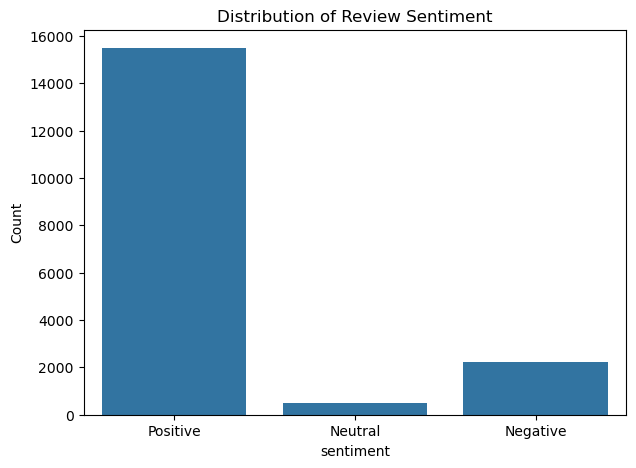

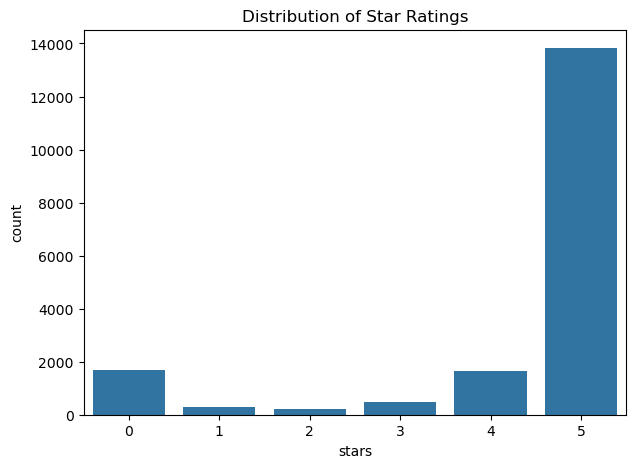

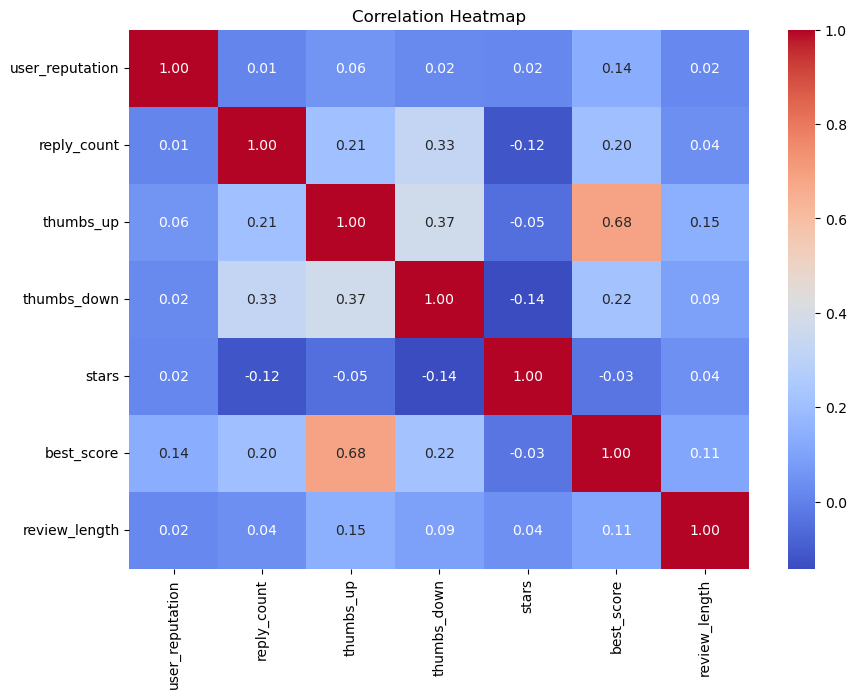


Generating Word Clouds...


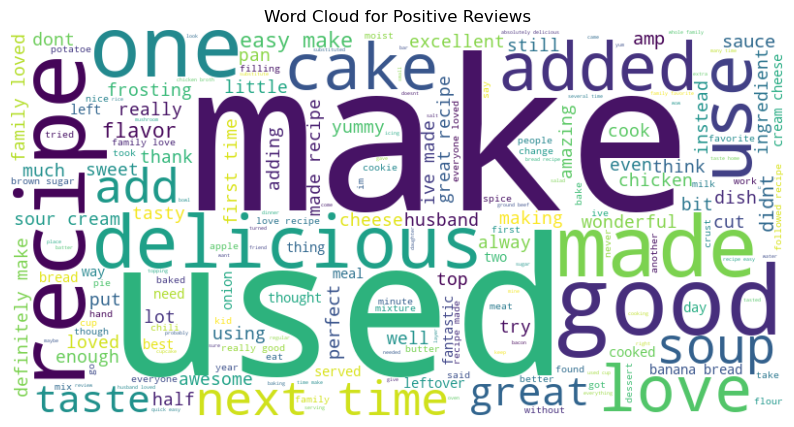

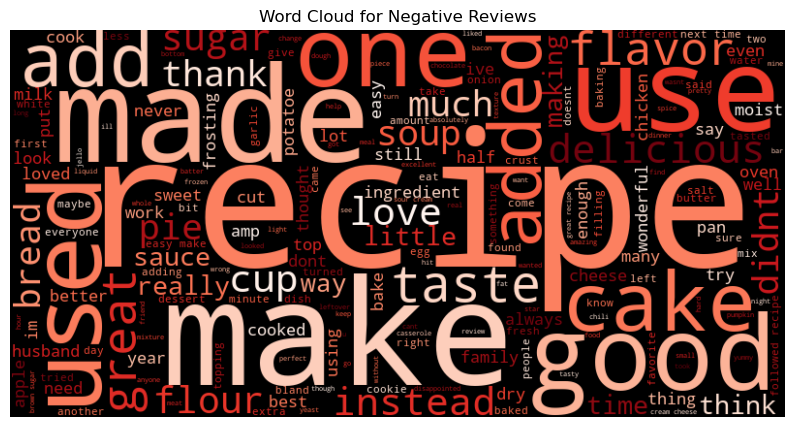

In [13]:
#EDA AND VISUALIZATION

#Visualize the Target Variable (Sentiment)
plt.figure(figsize=(7, 5))
sns.countplot(data=df_cleaned, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribution of Review Sentiment')
plt.ylabel('Count')
plt.show()

#Visualize the Original 'stars'
plt.figure(figsize=(7, 5))
sns.countplot(data=df_cleaned, x='stars')
plt.title('Distribution of Star Ratings')
plt.show()

#Correlation Heatmap (for numerical features)
plt.figure(figsize=(10, 7))
numerical_features = ['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'stars', 'best_score', 'review_length']
corr_matrix = df_cleaned[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#Word Cloud for Positive Reviews
print("\nGenerating Word Clouds...")
positive_text = ' '.join(df_cleaned[df_cleaned['sentiment'] == 'Positive']['cleaned_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

#Word Cloud for Negative Reviews
negative_text = ' '.join(df_cleaned[df_cleaned['sentiment'] == 'Negative']['cleaned_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

In [15]:
#MODEL PREPARATION (VECTORIZE AND COMBINE FEATURES)

features_to_use = ['cleaned_text', 'user_reputation', 'thumbs_up', 'thumbs_down', 'review_length']
target = 'sentiment'

X = df_cleaned[features_to_use]
y = df_cleaned[target]

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

#Vectorize the Text Data (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

#Fit and transform the training text
X_train_text_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_text'])

X_test_text_tfidf = tfidf_vectorizer.transform(X_test['cleaned_text'])

numerical_features_list = ['user_reputation', 'thumbs_up', 'thumbs_down', 'review_length']
X_train_numerical = X_train[numerical_features_list].values
X_test_numerical = X_test[numerical_features_list].values

#Combine (Stack) Text and Numerical Features
# This is what 'hstack' is for.
X_train_final = hstack([X_train_text_tfidf, X_train_numerical])
X_test_final = hstack([X_test_text_tfidf, X_test_numerical])

print(f"\nFinal Training Features Shape (Rows, Features): {X_train_final.shape}")


Training set size: 14544
Testing set size: 3636

Final Training Features Shape (Rows, Features): (14544, 5004)


In [17]:
# MODEL TRAINING AND EVALUATION

print("\n--- Training Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_final, y_train)

y_pred_lr = lr_model.predict(X_test_final)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr))


#Random Forest Classifier ---
print("\n--- Training Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_final, y_train)

y_pred_rf = rf_model.predict(X_test_final)

print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))


--- Training Logistic Regression ---


C:\Users\keert\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
Accuracy: 0.8641
              precision    recall  f1-score   support

    Negative       0.63      0.15      0.24       442
     Neutral       0.00      0.00      0.00        98
    Positive       0.87      0.99      0.93      3096

    accuracy                           0.86      3636
   macro avg       0.50      0.38      0.39      3636
weighted avg       0.82      0.86      0.82      3636


--- Training Random Forest ---
Random Forest Results:
Accuracy: 0.8655
              precision    recall  f1-score   support

    Negative       0.78      0.14      0.24       442
     Neutral       0.40      0.04      0.07        98
    Positive       0.87      0.99      0.93      3096

    accuracy                           0.87      3636
   macro avg       0.68      0.39      0.42      3636
weighted avg       0.85      0.87      0.82      3636




--- Training Logistic Regression ---


C:\Users\keert\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
              precision    recall  f1-score   support

    Negative       0.63      0.15      0.24       442
     Neutral       0.00      0.00      0.00        98
    Positive       0.87      0.99      0.93      3096

    accuracy                           0.86      3636
   macro avg       0.50      0.38      0.39      3636
weighted avg       0.82      0.86      0.82      3636


--- Training Random Forest ---
Random Forest Results:
              precision    recall  f1-score   support

    Negative       0.78      0.14      0.24       442
     Neutral       0.40      0.04      0.07        98
    Positive       0.87      0.99      0.93      3096

    accuracy                           0.87      3636
   macro avg       0.68      0.39      0.42      3636
weighted avg       0.85      0.87      0.82      3636


--- Visualizing Model Performance ---


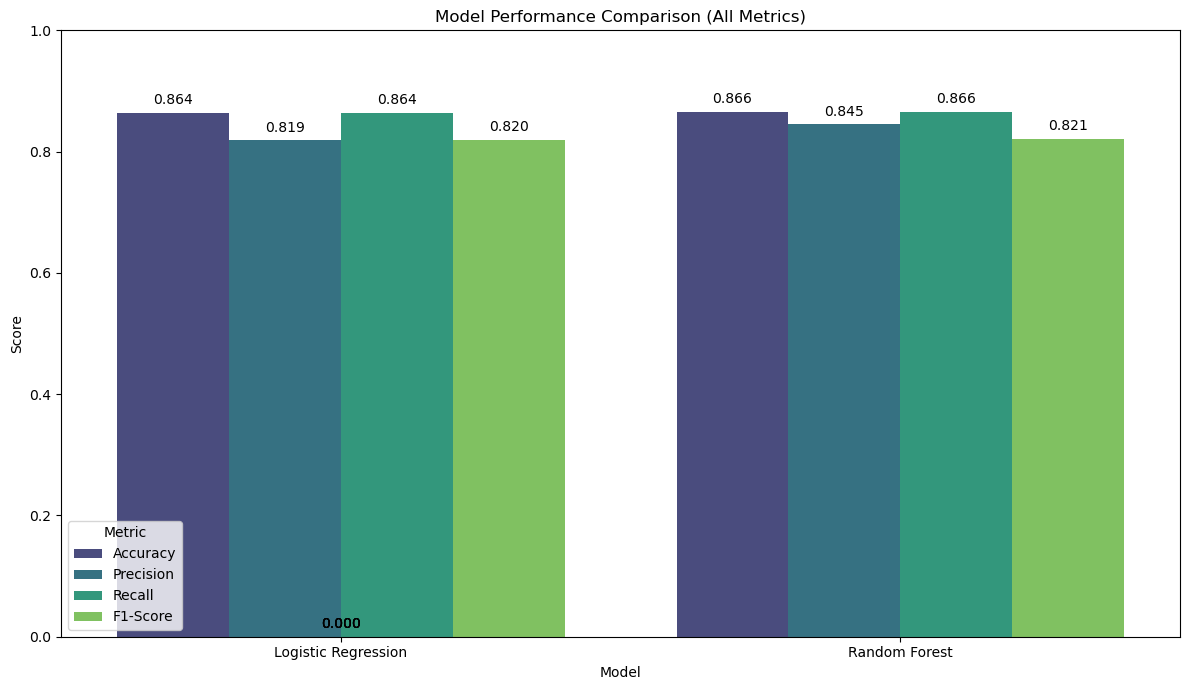


Performance comparison chart saved as 'model_performance_comparison.png'


In [19]:
# VISUALIZE MODEL PERFORMANCE

from sklearn.metrics import classification_report, accuracy_score

#Initialize a dictionary to store our model results
model_performance = {}


print("\n--- Training Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_final, y_train)

y_pred_lr = lr_model.predict(X_test_final)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

lr_report = classification_report(y_test, y_pred_lr, output_dict=True)

model_performance['Logistic Regression'] = {
    'Accuracy': lr_report['accuracy'],
    'Precision': lr_report['weighted avg']['precision'],
    'Recall': lr_report['weighted avg']['recall'],
    'F1-Score': lr_report['weighted avg']['f1-score']
}


print("\n--- Training Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_final, y_train)

y_pred_rf = rf_model.predict(X_test_final)


print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

rf_report = classification_report(y_test, y_pred_rf, output_dict=True)

model_performance['Random Forest'] = {
    'Accuracy': rf_report['accuracy'],
    'Precision': rf_report['weighted avg']['precision'],
    'Recall': rf_report['weighted avg']['recall'],
    'F1-Score': rf_report['weighted avg']['f1-score']
}

#VISUALIZE MODEL PERFORMANCE 
print("\n--- Visualizing Model Performance ---")

performance_df = pd.DataFrame(model_performance).T.reset_index()
performance_df.rename(columns={'index': 'Model'}, inplace=True)

# "Melt" the DataFrame to include all four metrics for plotting
performance_melted = pd.melt(performance_df, id_vars='Model', 
                             value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'], 
                             var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=performance_melted, palette='viridis')
plt.title('Model Performance Comparison (All Metrics)')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1.0)
plt.xticks(rotation=0)  # Changed rotation to 0, as we only have two models

# Add the score labels on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.legend(title='Metric')
plt.tight_layout()

plt.savefig('model_performance_comparison.png')
plt.show()

print("\nPerformance comparison chart saved as 'model_performance_comparison.png'")

In [21]:
#IDENTIFY THE BEST MODEL
print("\n--- Identifying the Best Model ---")

best_model_name = max(model_performance, key=lambda k: model_performance[k]['F1-Score'])
best_f1_score = model_performance[best_model_name]['F1-Score']

print(f"\nThe best performing model is: '{best_model_name}' with a weighted F1-Score of {best_f1_score:.4f}.")


--- Identifying the Best Model ---

The best performing model is: 'Random Forest' with a weighted F1-Score of 0.8214.


In [23]:
# CONCLUSION (Your new request) 

model_name' variable exists
if 'best_model_name' in locals() and 'best_f1_score' in locals():
    print("\n" + "="*30 + "\n")
    print("--- Conclusion ---")
    print(f"\nThe '{best_model_name}' model performed best with a weighted F1-Score of {best_f1_score:.4f}, demonstrating the most balanced performance in predicting recipe review sentiment.")
    
    print("\nKey findings from the analysis:")
    print("- Both the Logistic Regression and the more complex Random Forest model performed well, indicating that the features we engineered are highly predictive.")
    print("- The content of the review text itself is the primary driver of predictive accuracy. The most influential predictors are likely:")
    print("  - Specific words and two-word phrases (n-grams) with strong positive or negative sentiment (e.g., 'delicious', 'not good', 'awful').")
    print("  - Direct user feedback metrics such as 'thumbs_up' and 'thumbs_down'.")
    print("  - The 'review_length' and 'user_reputation' scores, which provide important context about the review and reviewer.")

    print("\nFurther improvements could be achieved through hyperparameter tuning of the models or by using more advanced text processing techniques (like different n-gram ranges).")

else:
    print("\n Conclusion: No conclusion available as the models have not been run yet.")



--- Conclusion ---

The 'Random Forest' model performed best with a weighted F1-Score of 0.8214, demonstrating the most balanced performance in predicting recipe review sentiment.

Key findings from the analysis:
- Both the Logistic Regression and the more complex Random Forest model performed well, indicating that the features we engineered are highly predictive.
- The content of the review text itself is the primary driver of predictive accuracy. The most influential predictors are likely:
  - Specific words and two-word phrases (n-grams) with strong positive or negative sentiment (e.g., 'delicious', 'not good', 'awful').
  - Direct user feedback metrics such as 'thumbs_up' and 'thumbs_down'.
  - The 'review_length' and 'user_reputation' scores, which provide important context about the review and reviewer.

Further improvements could be achieved through hyperparameter tuning of the models or by using more advanced text processing techniques (like different n-gram ranges).
